In [1]:
import numpy as np
import tensorflow as tf

Generate Position Encoding

In [ ]:
import numpy as np
import tensorflow as tf


def createAngleRates(d_model):
    """
    Creates angle rates for positional encoding calculation in the Transformer model.
    
    This function generates the angle rates used in the positional encoding formula:
    angle_rates = 1 / (10000 ** (2i/d_model)) where i is the dimension.
    
    Args:
        d_model (int): so chieu cua embedding vector cua model
        
    Returns:
        numpy.ndarray: A 1xd_model matrix containing the angle rates
    """
    angles = np.arange(d_model)                 # tao array tu 0 den d_model - 1 (0, 1, ..., d_model - 1)
    angles[1::2] = angles[0::2]                 # copy value tu o chan sang o le -> [0, 0, 2, 2, ...]
    angles = 1 / (10000 ** (angles / d_model))  # tinh angle rate
    angles = np.expand_dims(angles, axis=0)     # vi sao phai them chieu ? dee ty nua matrix pos co shape (seq_length, 1), nhan voi matrix pos co shape (1, d_model)
    return angles                               # return matrix co shape (1, d_model)
                                            # seq_length chinh la pos
def generate_positional_encoding(pos, d_model):
    """
    Generates positional encodings for the Transformer model.
    
    This function implements the positional encoding as described in the paper
    "Attention Is All You Need". The encoding uses sine and cosine functions of different
    frequencies to create unique position embeddings:
    PE(pos, 2i) = sin(pos / 10000^(2i/d_model))
    PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
    
    Args:
        pos (int): Maximum sequence length for which to generate position encodings
        d_model (int): The dimension of the model's embedding vectors
        
    Returns:
        tensorflow.Tensor: A tensor of shape (1, pos, d_model) containing the positional
                         encodings for all positions up to pos
    """                                                 # no chi khac nhau o pos thoi, nen minh tinh chung roi nhan voi pos sau
    angles = createAngleRates(d_model)                  # return angle_matrix co shape (1, d_model) 
    pos = np.expand_dims(np.arange(pos), axis=1)        # bien pos thanh ma tran [0, 1, ..., pos - 1], sau khi expand  dims co shape = (pos, 1)
    pos_angles = pos.dot(angles)                        # tinh pos_angles co shape = (pos, d_model) CT: pos / 10000^(2i/d_model)
    pos_angles[:, 0::2] = np.sin(pos_angles[:, 0::2])   # tai tat ca cac hang cua pos_angles, tuong ung voi tung tu trong cau, tai cac o
                                                        # co vi tri chan, su dung ham sin
    pos_angles[:, 1::2] = np.cos(pos_angles[:, 1::2])   # tuong tu su dung cos voi o le
    pos_angles = np.expand_dims(pos_angles, axis=0)     # bien pos_angle thanh matrix co shape = (1, pos, d_model)
                                                         
    return tf.cast(pos_angles, dtype=tf.float32)


Khi đã implement xong Pos encoding, sử dụng để build class encoder</br>
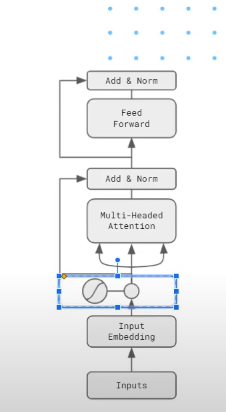

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dropout
from transformer.layers.encoder_layer import EncoderLayer
from transformer.layers.generate_position import generate_positional_encoding


class Encoder(tf.keras.layers.Layer):
    """
    Encoder trong mô hình Transformer.

    Encoder bao gồm các thành phần chính:
    1. Word Embedding: Chuyển đổi các từ thành vector embedding
    2. Positional Encoding: Thêm thông tin về vị trí của từng từ trong câu
    3. N lớp Encoder Layer: Mỗi lớp có Multi-Head Attention và Feed Forward Network

    Attributes:
        n (int): Số lượng Encoder Layer (số lớp xếp chồng)
        h (int): Số lượng head trong Multi-Head Attention
        vocab_size (int): Kích thước từ điển (số lượng từ khác nhau)
        d_model (int): Số chiều của vector embedding và hidden states
        d_ff (int): Số chiều của Feed Forward Network
        activation (str): Hàm kích hoạt trong Feed Forward Network
        dropout_rate (float): Tỉ lệ dropout để chống overfitting
        eps (float): Epsilon dùng trong Layer Normalization
    """
    def __init__(self, n, h, vocab_size, d_model, d_ff, activation, dropout_rate=0.1, eps=0.1):
        """
        Khởi tạo Encoder.

        Args:
            n (int): Số lượng Encoder Layer
            h (int): Số lượng head trong Multi-Head Attention
            vocab_size (int): Kích thước từ điển
            d_model (int): Số chiều của vector embedding
            d_ff (int): Số chiều của Feed Forward Network
            activation (str): Hàm kích hoạt (e.g., 'relu')
            dropout_rate (float, optional): Tỉ lệ dropout. Defaults to 0.1
            eps (float, optional): Epsilon cho Layer Normalization. Defaults to 0.1
        """
        super(Encoder, self).__init__()
        self.n = n
        self.d_model = d_model
        self.encoder_layers = [EncoderLayer(h, d_model, d_ff, activation, dropout_rate, eps) for _ in range(n)]
        self.word_embedding = Embedding(vocab_size, output_dim=d_model)
        self.dropout = Dropout(dropout_rate)

    def call(self, q, is_train, mask=None):
        """
        Thực hiện quá trình encoding cho câu đầu vào.

        Các bước xử lý:
        1. Chuyển đổi từng từ thành vector embedding
        2. Scale embedding bằng căn bậc hai của d_model
        3. Thêm positional encoding
        4. Áp dụng dropout
        5. Đưa qua các encoder layer

        Args:
            q (tensor): Query - Câu đầu vào dưới dạng chuỗi các chỉ số trong từ điển
                       Ví dụ: câu "I love you" -> [5, 20, 15] với 5,20,15 là chỉ số trong từ điển
                       Shape: (..., q_length) với q_length là độ dài câu
            is_train (bool): Flag chỉ định đang trong quá trình training hay không
            mask (tensor, optional): Mask để che giấu một số từ. Defaults to None
                                  Shape: (..., q_length, q_length)

        Returns:
            tensor: Biểu diễn mới của câu sau khi qua encoder
                   Shape: (..., q_length, d_model)
                   Mỗi từ ban đầu được biểu diễn bởi vector d_model chiều
        """
        seq_length = q.shape[1]  # Độ dài của câu đầu vào
        
        # Chuyển đổi từ thành vector embedding
        # Mỗi chỉ số trong q được chuyển thành vector d_model chiều
        # Shape: (..., q_length, d_model)
        embedded_q = self.word_embedding(q)

        # Scale embedding để tránh gradient quá lớn
        embedded_q *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))

        # Thêm positional encoding để mô hình biết vị trí của từng từ
        # Shape: (1, q_length, d_model)
        positional_encoding = generate_positional_encoding(seq_length, self.d_model)

        # Áp dụng dropout và cộng với positional encoding
        encoder_out = self.dropout(embedded_q + positional_encoding, training=is_train)

        # Đưa qua từng encoder layer
        for encoder_layer in self.encoder_layers:
            encoder_out = encoder_layer(encoder_out, is_train, mask)
        
        return encoder_out


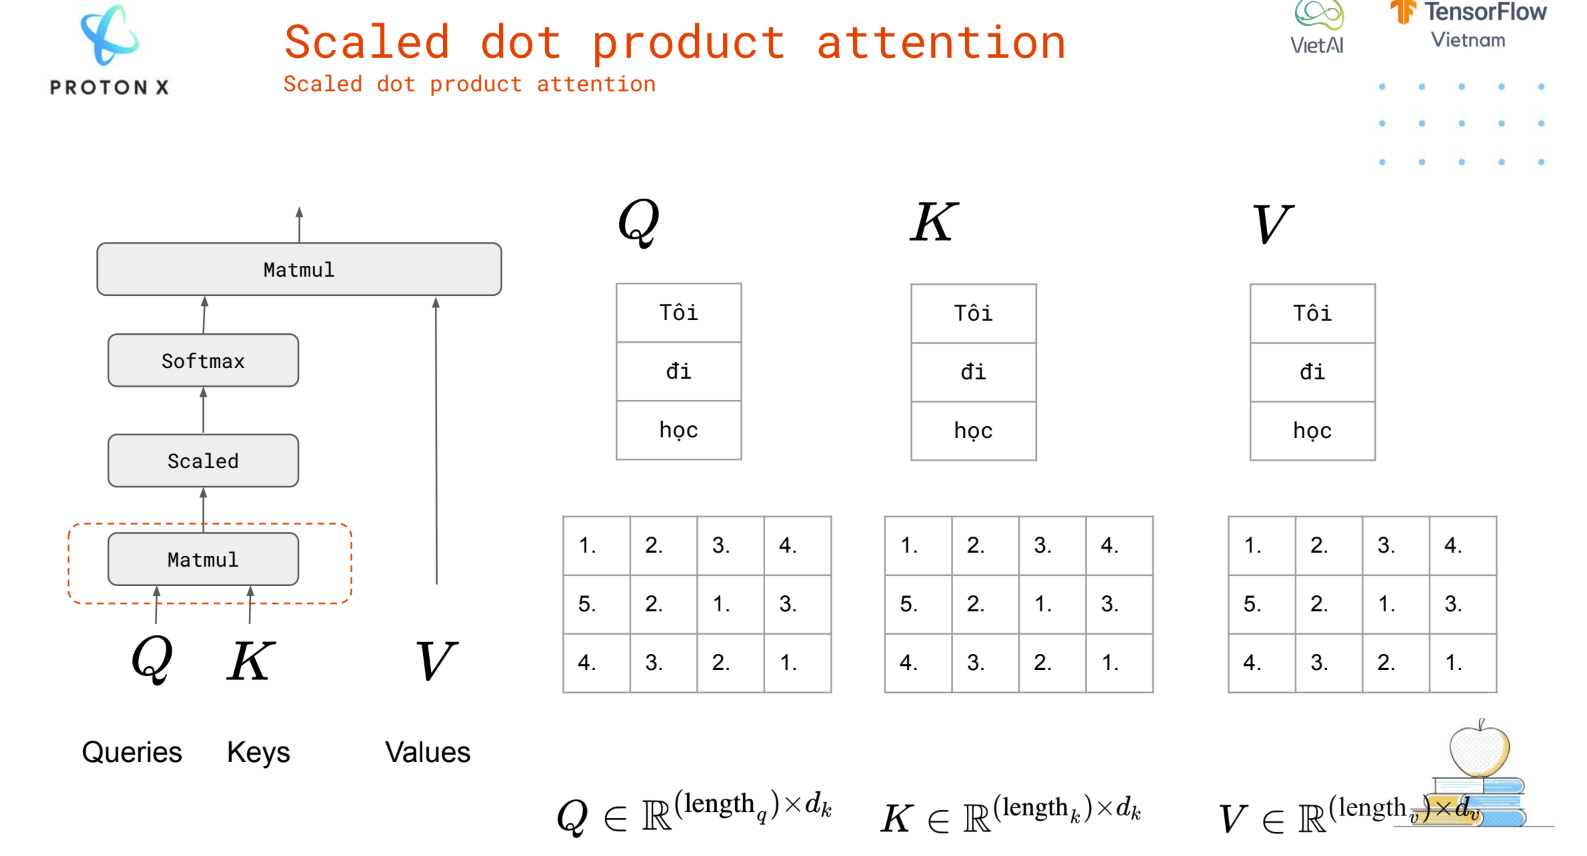</br>
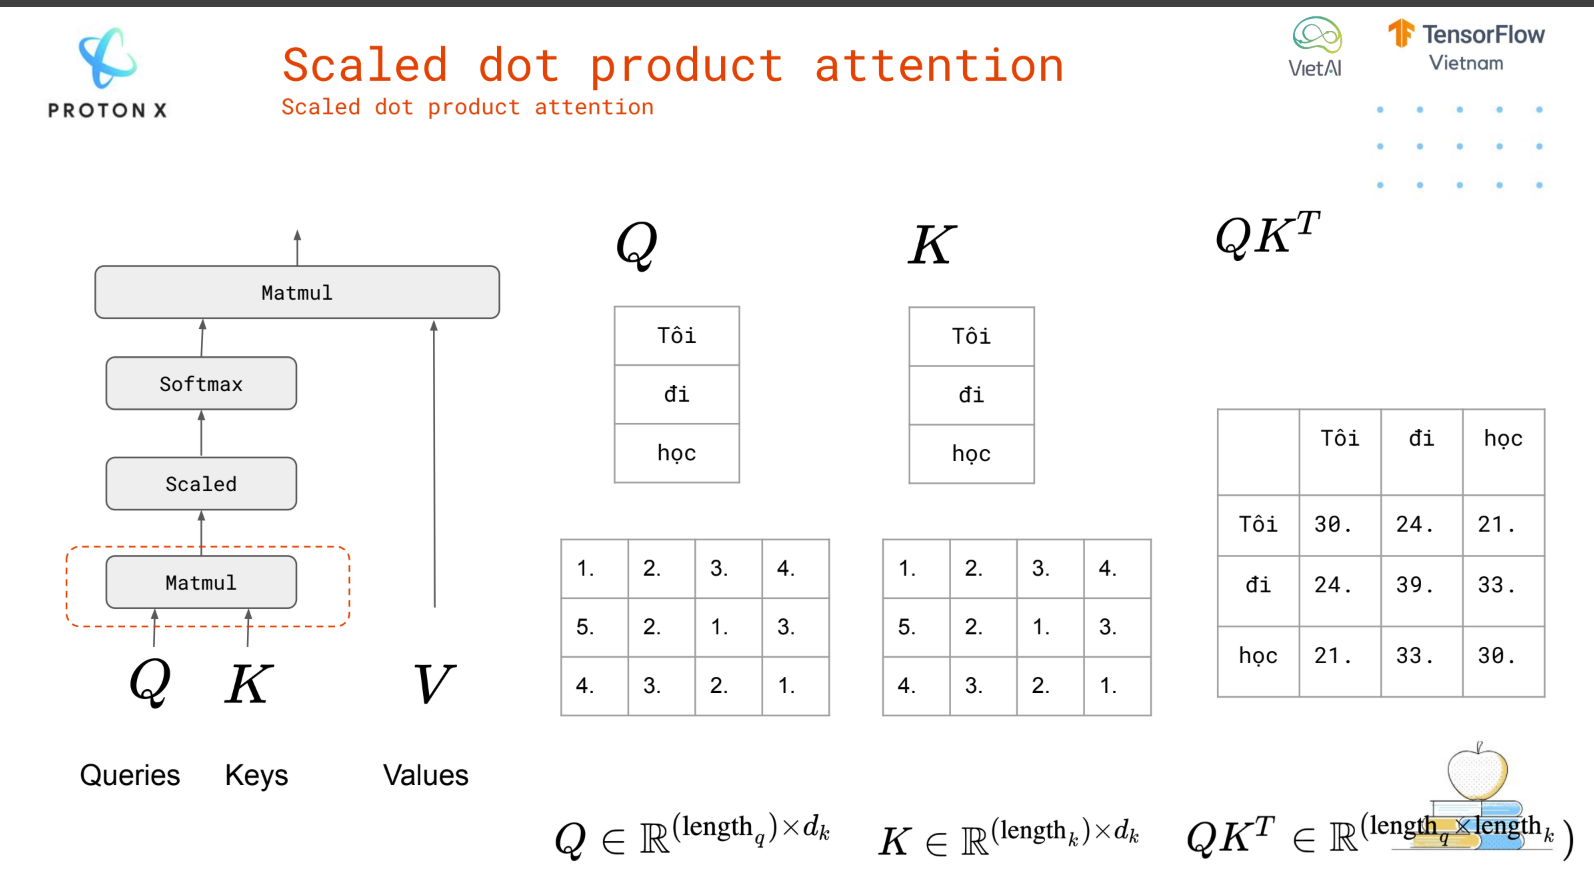
`length_q, k, v và d_q, k, v đều bằng nhau, nhưng ở đây, để tổng quát, ta viết bằng kí hiệu riêng biệt `